In [ ]:
!wget https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz

--2022-05-18 05:59:40--  https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz [following]
--2022-05-18 05:59:40--  https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8718893 (8.3M) [application/octet-stream]
Saving to: ‘korean-english-park.train.tar.gz.1’

korean-e

In [ ]:
!tar -xzvf korean-english-park.train.tar.gz

korean-english-park.train.en
korean-english-park.train.ko


- 네이버 영화리뷰 감정 분석 코퍼스에 SentencePiece를 적용시킨 모델 학습하기
- 학습된 모델로 sp_tokenize() 메소드 구현하기
- 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습하기
- KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기
- (보너스) SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기

In [ ]:
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import re
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

In [ ]:
# 학습 데이터를 가져온다..
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt") # train
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt") # test
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt") # train + test

('ratings.txt', <http.client.HTTPMessage at 0x7f597e372750>)

In [ ]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')
train_data[:5]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
print(type(train_data['document']))

train_data['document'][:10]

<class 'pandas.core.series.Series'>


0                                  아 더빙.. 진짜 짜증나네요 목소리
1                    흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
2                                    너무재밓었다그래서보는것을추천한다
3                        교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
4    사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...
5        막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.
6                                원작의 긴장감을 제대로 살려내지못했다.
7    별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...
8                               액션이 없는데도 재미 있는 몇안되는 영화
9        왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?
Name: document, dtype: object

In [ ]:
!pip install sentencepiece

In [ ]:
import sentencepiece as spm

In [ ]:
corpus = 'ratings_train.txt' # 입력 copus
prefix = "korean_spm" # 저장할 단어장 이름
vocab_size = 8000

# SentencePiece를 corpus 자료를 가지고 훈련한다.
spm.SentencePieceTrainer.Train(
    f"--input={corpus} --model_prefix={prefix} --vocab_size={vocab_size}" + 
    " --model_type=bpe" +
    " --max_sentence_length=999999" # 문장 최대 길이
)

In [ ]:
sp = spm.SentencePieceProcessor()
sp.Load('korean_spm.model')

def sp_tokenize(sp, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(sp.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

In [ ]:
# 1) 매개변수로 토큰화된 문장의 list를 전달하는 대신 온전한 문장의 list 를 전달합니다.

# 2) 생성된 vocab 파일을 읽어와 { <word> : <idx> } 형태를 가지는 word_index 사전과 { <idx> : <word>} 형태를 가지는 index_word 사전을 생성하고 함께 반환합니다.

# 3) 리턴값인 tensor 는 앞의 함수와 동일하게 토큰화한 후 Encoding된 문장입니다. 바로 학습에 사용할 수 있게 Padding은 당연히 해야겠죠?

In [ ]:
# sp_tokenize(s, corpus) 사용예제

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(sp, my_corpus)
print(tensor)

[[ 842 3359 6409  693  970 6374    0    0    0]
 [1912 3050  473  122 6392  204 7709   21   12]]


In [ ]:
train_data.drop_duplicates(subset=['document'], inplace=True)
test_data.drop_duplicates(subset=['document'], inplace=True)

In [ ]:
train_data = train_data.dropna(how="any")
test_data = test_data.dropna(how="any")

In [ ]:
x_train = train_data['document']
y_train = train_data['label']

x_test = test_data['document']
y_test = test_data['label']

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(146182,) (146182,)
(49157,) (49157,)


In [ ]:
# 전처리에서 nan을 제거하지 않으면 not string 에러 발생
# data의 중복 제거안해도 not string 에러 발생
x_train_tensor, x_train_word_index, x_train_index_word  = sp_tokenize(sp, x_train)
x_test_tensor, x_test_word_index, x_test_index_word  = sp_tokenize(sp, x_test)

x_val = x_train_tensor[:50000]
y_val = y_train[:50000]

partial_x_train = x_train_tensor[50000:]
partial_y_train = y_train[50000:]

In [ ]:
print(len(x_val), len(y_val))
print(len(partial_x_train), len(partial_y_train))

print(x_val)

50000 50000
96182 96182
[[  10 1238    5 ...    0    0    0]
 [1866   12 5932 ...    0    0    0]
 [  34 6417 7994 ...    0    0    0]
 ...
 [4207 6385 6435 ...    0    0    0]
 [1110 3735 3203 ...    0    0    0]
 [ 275 6437 1754 ...    0    0    0]]


In [ ]:
# 단어 하나를 표현하는 임베딩 벡터의 차원
# dropout 및 return_sequences가 없으면 loss가 잘 줄지 않는다.
word_vector_dim = 16 # 2의 배수

model = keras.Sequential(name = 'LSTM')
model.add(
    keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))
)
model.add(keras.layers.LSTM(32, return_sequences = True))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.LSTM(32, return_sequences = True))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 16)          128000    
                                                                 
 lstm_1 (LSTM)               (None, None, 32)          6272      
                                                                 
 dense_3 (Dense)             (None, None, 32)          1056      
                                                                 
 dropout (Dropout)           (None, None, 32)          0         
                                                                 
 lstm_2 (LSTM)               (None, None, 32)          8320      
                                                                 
 dropout_1 (Dropout)         (None, None, 32)          0         
                                                                 
 dense_4 (Dense)             (None, None, 1)           33     

In [ ]:
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])
epochs = 10
history = model.fit(partial_x_train, partial_y_train, epochs = epochs, batch_size=512, validation_data=(x_val, y_val), verbose=1 )

NameError: ignored

In [ ]:
# fit()주어진 입력(및 해당 교육 레이블)을 사용하여 모델을 교육하기 위한 것입니다.
# evaluate()검증(또는 테스트) 데이터와 해당 레이블을 사용하여 이미 훈련된 모델을 평가하기 위한 것입니다. 모델에 대한 손실 값 및 메트릭 값을 반환합니다.
# predict()실제 예측을 위한 것입니다. 입력 샘플에 대한 출력 예측을 생성합니다.

results = model.evaluate(x_test_tensor, y_test, verbose=2)

1537/1537 - 28s - loss: 0.3993 - accuracy: 0.8294 - 28s/epoch - 18ms/step


In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: ignored

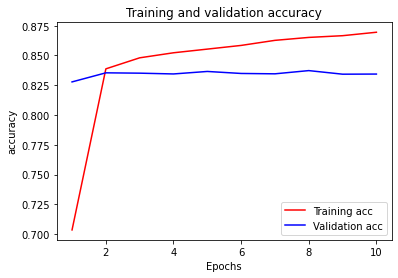

In [ ]:
plt.clf() #그림을 초기화

plt.plot(epochs, acc, 'r-', label= 'Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'r-', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: ignored